# PPO-2

### An example of GAE given by ChatGPT

In [47]:
import numpy as np

states = np.array([0.1, 0.5, 0.8, 0.3])  
rewards = np.array([1, 1, 0, 1])  
values = np.array([0.2, 0.4, 0.7, 0.1]) 


td_errors = rewards + 0.9 * np.append(values[1:], 0) - values


gamma = 0.9
lmbda = 0.95
advantage = 0
advantages = []
for delta in td_errors[::-1]:  
    advantage = gamma * lmbda * advantage + delta
    advantages.append(advantage)
advantages.reverse()

print("TD Errors:", td_errors)
print("Advantages:", advantages)

TD Errors: [ 1.16  1.23 -0.61  0.9 ]
Advantages: [2.3282484875, 1.3663725, 0.15949999999999998, 0.9]


## Using PPO in CartPole

In [48]:
import torch
import torch.nn as nn
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils import rl_utils

In [49]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.input = nn.Linear(state_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.input(x))
        return F.softmax(self.output(x), dim = 1)
    

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.input = nn.Linear(state_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        return self.output(x)


In [50]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, eps, epochs, device, lmbda):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.gamma = gamma
        self.device = device
        self.eps = eps
        self.epochs = epochs
        self.lmbda = lmbda

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float, device=self.device)
        probs = self.actor(state)
        policy = torch.distributions.Categorical(probs)
        action = policy.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float, device=self.device)
        actions = torch.tensor(transition_dict['actions'], device=self.device).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], device=self.device).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float, device=self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float, device=self.device).view(-1, 1)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        td_delta = td_delta.detach().numpy()
        advantage = 0
        advantage_list = []
        for delta in td_delta[::-1]:
            advantage = self.lmbda * self.gamma * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = torch.tensor(advantage_list, dtype=torch.float).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            probs = torch.log(self.actor(states).gather(1, actions))
            term1 = torch.exp(probs - old_log_probs) * advantage
            term2 = torch.clamp(torch.exp(probs - old_log_probs), min=1-self.eps, max=1+self.eps) * advantage
            actor_loss = torch.mean(-torch.min(term1, term2))
            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optim.zero_grad()
            self.critic_optim.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optim.step()
            self.critic_optim.step()

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
gamma = 0.98
lmbda = 0.95
epochs = 5
eps = 0.2
torch.manual_seed(0)
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, eps, epochs, device, lmbda)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 50/50 [00:01<00:00, 34.36it/s, episode=500, return=200.000]


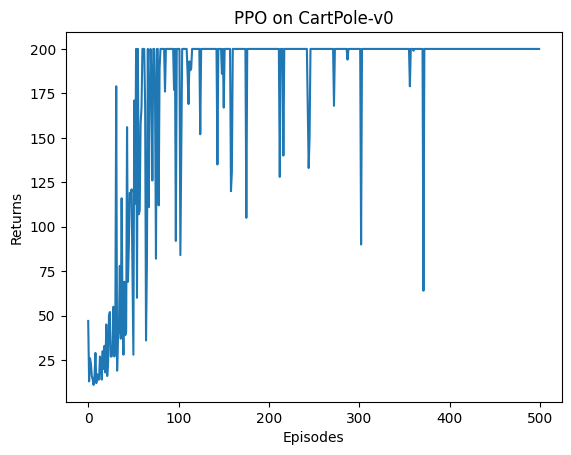

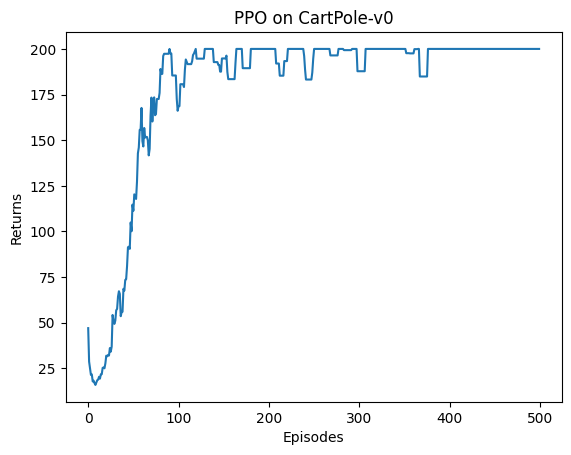

In [52]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()